# Visualization by flipping

Flipping the top pixels and see how much accuracy it lasts and it imputes

In [15]:
%matplotlib inline
import torch
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

import exp.utils_visualise as utils_visualise
import matplotlib.pyplot as plt
import numpy as np
from exp.loaddata_utils import ImageNetLoadClass
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import rc
import matplotlib.pylab as plt
from arch.DeepLiftNet import DeepLiftNet
from arch.Inpainting.Baseline import MeanInpainter
import operator
from collections import OrderedDict
import operator
import copy

def get_file_names(directory):
    directory = os.path.join('../result', directory)
    result = []
    for filename in os.listdir(directory):
        if filename.endswith("records.th"): 
            result.append(filename)
    return result

def get_file_paths(directory):
    directory = os.path.join('../result', directory)
    result = []
    for filename in os.listdir(directory):
        if filename.endswith("records.th"): 
            result.append(os.path.join(directory, filename))
    return result

def sort_asd_2d(nd_arr):
    ''' (np arr) -> tuple
    Sort 2d array and return an order by ascending order
    :param nd_arr
    :return: a tuple of array of index. first element is index 1, 2nd element is index 2.
    '''
    return np.unravel_index(np.argsort(nd_arr.ravel()), nd_arr.shape)

def mask_gen_to_flip_top_pixels(importance_2d, num_pixels):
    rank = sort_asd_2d(-importance_2d)
    H, W = importance_2d.shape
    mask = torch.ones(1, 1, H, W)

    for i in xrange(num_pixels[-1] + 1):
        mask[0, 0, rank[0][i], rank[1][i]] = 0.
        if (i + 1) in num_pixels:
            yield mask

def mask_gen_to_keep_top_pixels(importance_2d, num_pixels):
    rank = sort_asd_2d(importance_2d)
    H, W = importance_2d.shape
    mask = torch.ones(1, 1, H, W)
    
    if 0 in num_pixels:
        yield mask

    for i in xrange(num_pixels[-1] + 1):
        mask[0, 0, rank[0][i], rank[1][i]] = 0.
        if (i + 1) in num_pixels:
            yield mask
    
def log_sum_exp(x, dim):
    x_max = x.max()
    return torch.log(torch.sum(torch.exp(x - x_max), dim=dim)) + x_max            

def get_log_odds_ratio(image, interpret_net, from_class=8, to_class=3):
    if not isinstance(image, torch.Tensor):
        image = torch.FloatTensor(image)
    
    if image.ndimension() == 3:
        image = image.unsqueeze(0)
    pre_softmax_score = interpret_net.forward(Variable(image, volatile=True))
    
    if to_class is not None:
        logodds_diff = pre_softmax_score[:, from_class] - pre_softmax_score[:, to_class]
    else:
        log_prob = F.log_softmax(pre_softmax_score)
        other_log_prob = torch.cat([log_prob[:, :from_class],
                                    log_prob[:, (from_class + 1):]], dim=1)
        tmp = log_sum_exp(other_log_prob, dim=1)
        logodds_diff = (log_prob[:, from_class] - tmp)
        
    return logodds_diff.data[0]

def get_all_log_odds(imp_vector, orig_img, interpret_net, impant_model, from_class=8, to_class=3,
                     mask_mode=mask_gen_to_flip_top_pixels):
    mask_generator = iter(mask_mode(imp_vector, range(1, 28 * 28)))
    
    the_dict = OrderedDict()
    for idx, mask in enumerate(mask_generator):
        regenerated = impant_model.impute_missing_imgs(orig_img.unsqueeze(0), mask)

        logodds = get_log_odds_ratio(regenerated, interpret_net, from_class, to_class)
        the_dict[idx + 1] = -logodds
    
    orig_odds = get_log_odds_ratio(orig_img, interpret_net, from_class, to_class)
    the_dict[0] = -orig_odds
    return the_dict

def plot_given_file(ax, filepath, name):
    orig_log_odds, all_log_odds, unnormalized_img, imp_vector, rodds = \
        torch.load(filepath)
    x_flip = np.array([0] + all_log_odds.keys())
    y_flip = np.array([orig_log_odds] + all_log_odds.values())

    ax.plot(x_flip, y_flip, label='{} flip'.format(name))
    
    if 'p_b' not in name:
        x = [k for k, v in rodds]
        y = np.array([v for k, v in rodds])
        ax.scatter(x, y, label='{} random'.format(name))
    return unnormalized_img


def _plot_imp_vector(original_pth_img, imp_vector_dict, axes):
    # Plot from left to right. The most left is the original image.
    # And plot image with the overlayed color image
    # @param original_pth_img: Needs to have (1, 28, 28) pytorch image
    assert 1 + len(imp_vector_dict) == len(axes), 'different! {} != {}'.format(
        1 + len(imp_vector_dict), len(axes))
    
    utils_visualise.plot_pytorch_img(original_pth_img.expand(3, 28, 28), axes[0])
    axes[0].set_title('Original Image', fontsize=20)
    axes[0].set_ylabel('Saliency', fontsize=20)
    
    for idx, method_name in enumerate(imp_vector_dict):
        imp_vector = imp_vector_dict[method_name][0]
        overlayed_img, clim = utils_visualise.get_overlayed_image(original_pth_img, imp_vector)

        # Plot colored image
        im2 = utils_visualise.plot_pytorch_img(overlayed_img, axes[1 + idx])
        axes[1 + idx].set_title(method_name, fontsize=20)

def _plot_imputed_img(original_pth_img, orig_log_odds, flipped_img_dict, axes,
                      show_log_odds=True, show_mask_number=True, title='Masked Image'):
    # @param flipped_img_dict:
    #     - Map ('method_name' => [(plot_img, logodd, num_flip_pixel)])
    assert 1 + len(flipped_img_dict) == len(axes), 'different! {} != {}'.format(
        1 + len(flipped_img_dict), len(axes))
    
    utils_visualise.plot_pytorch_img(original_pth_img.expand(3, 28, 28), axes[0])
    axes[0].set_ylabel(title, fontsize=20)
    if show_log_odds:
        axes[0].set_xlabel('{:.1f}'.format(orig_log_odds), fontsize=20)
    
    for idx, method_name in enumerate(flipped_img_dict):
        plot_img, logodd, num_flip_pixel = flipped_img_dict[method_name][0]

        # Plot colored image
        im2 = utils_visualise.plot_pytorch_img(plot_img.expand(3, 28, 28), axes[1 + idx])
        if show_mask_number:
            axes[1 + idx].set_title('{} mask'.format(num_flip_pixel), fontsize=20)
        if show_log_odds:
            axes[1 + idx].set_xlabel('{:.1f}'.format(logodd), fontsize=20)

def get_twenty_percent_value(all_log_odds):
    num_pixels = int(28 * 28 / 5) # 20%
    return num_pixels, all_log_odds[num_pixels]
            
def get_max_value(all_log_odds):
    max_num_pixels, max_vals = max(all_log_odds.iteritems(), key=operator.itemgetter(1))
    return max_num_pixels, max_vals

def get_min_value(all_log_odds):
    min_num_pixels, min_vals = min(all_log_odds.iteritems(), key=operator.itemgetter(1))
    return min_num_pixels, min_vals

def _get_dicts(label_arrs, impant_model, from_class=8, to_class=3, retrieve_func=get_max_value,
               mask_mode=mask_gen_to_flip_top_pixels):
    imp_vector_dict = OrderedDict()
    all_log_odds_dict = OrderedDict()
    orig_arr = []
    
    # I want to append the original image but just once. So I would select a method but not Deeplift 
    # with original image.
    select_method_name = [content[0] for content in label_arrs if content[0] != 'DeepLift'][0]
    
    for idx, content in enumerate(label_arrs):
        method_name = content[0]
        file_paths = content[1]
        if len(content) > 2:
            impant_model = content[2]
        
        imp_vectors_arr = []
        log_odd_arr = []

        for idx, file_path in enumerate(file_paths):
            # Get the original pytorch image (1, 1, 28, 28). Assume the first item is PDA or VD
            if not method_name.startswith('DeepLift'):
                _, _, unnormalized_img, imp_vector, _ = torch.load(file_path)
                if method_name == select_method_name:
                    orig_log_odds = get_log_odds_ratio(unnormalized_img, interpret_net, 
                                                       from_class=from_class, to_class=to_class)
                    orig_arr.append((unnormalized_img[0], orig_log_odds))
                    is_the_first_time = False
                
                if 'BBMP' in method_name and 'SDR' in method_name:
                    imp_vector += 1
                if 'BBMP' in method_name: # Make 0.5 as white
                    imp_vector -= 0.5
            else:
                log_odds, x_test, y_test = torch.load('../result/1018-deeplift/mnist_deeplift_scores.pth')
                img_idx = content[3][idx]

                real_idx = np.arange(10000)[y_test == from_class][img_idx]
                
                unnormalized_img = torch.from_numpy(x_test[real_idx])
                
                imp_vector = log_odds[from_class][real_idx][0]
                if to_class is not None:
                    imp_vector -= log_odds[to_class][real_idx][0]

            imp_vectors_arr.append(imp_vector)
            
            all_log_odds = get_all_log_odds(imp_vector, unnormalized_img, interpret_net, impant_model,
                                            from_class=from_class, to_class=to_class,
                                            mask_mode=mask_mode)
            
            max_num_pixels, max_vals = retrieve_func(all_log_odds)
#             max(all_log_odds.iteritems(), key=operator.itemgetter(1))

            the_mask = iter(mask_mode(imp_vector, [max_num_pixels])).next()
            regenerated = impant_model.impute_missing_imgs(unnormalized_img.unsqueeze(0), the_mask)
            # Sanity check        
#             log_odds = get_log_odds_ratio(regenerated, interpret_net, from_class=from_class, to_class=to_class)
#             assert log_odds == -max_vals, 'Different logodds value: {} != {}'.format(log_odds, -max_vals)
#             print log_odds
            
            log_odd_arr.append((regenerated[0, ...], -max_vals, max_num_pixels))
        imp_vector_dict[method_name] = imp_vectors_arr
        all_log_odds_dict[method_name] = log_odd_arr
        
    return orig_arr, imp_vector_dict, all_log_odds_dict

def plot_comparison(label_arrs, impant_model=MeanInpainter(), is_vae=False, from_class=8, to_class=3):
    num_methods = len(label_arrs)
    print 'num_methods:', num_methods

    # Construct important vector's dictionary
    orig_arr, imp_vector_dict, all_log_odds_dict = _get_dicts(label_arrs, impant_model, from_class, to_class,
                                                              retrieve_func=get_max_value)
    fig, axes = _plot_comparisons_images(num_methods, orig_arr, imp_vector_dict, 
                                         all_log_odds_dict, is_vae=is_vae)
    
    for ax1 in axes:
        for ax in ax1:
            ax.set_xticks([], [])
            ax.set_yticks([], [])
    print 'Done!'
    return fig

def plot_comparison_keep_region(label_arrs, impant_model=MeanInpainter(), is_vae=False, 
                                from_class=8, to_class=3, percs=None):
    num_methods = len(label_arrs)
    print 'num_methods:', num_methods
    
    def create_retrieve_func(idx):
        def tmp(all_log_odds):
            return idx, all_log_odds[idx]
        return tmp
    
    if percs is not None:
        fig, axes = plt.subplots(1 + len(percs), 1 + num_methods, 
                                 figsize=(num_methods * 4, 3 * (1 + len(percs))))
        for k, perc in enumerate(percs):
            num_flip = int(perc * 28 * 28)

            the_func = create_retrieve_func(num_flip)
            # Construct important vector's dictionary
            orig_arr, imp_vector_dict, all_log_odds_dict = _get_dicts(label_arrs, impant_model, from_class, to_class,
                                                                      retrieve_func=the_func,
                                                                      mask_mode=mask_gen_to_keep_top_pixels)
            if k == 0:
                _plot_imp_vector(orig_arr[0][0], imp_vector_dict, axes[0])
            _plot_imputed_img(orig_arr[0][0], orig_arr[0][1], all_log_odds_dict, axes[1 + k])
    else:
        # Construct important vector's dictionary
        orig_arr, imp_vector_dict, all_log_odds_dict = _get_dicts(label_arrs, impant_model, from_class, to_class,
                                                                  retrieve_func=get_min_value,
                                                                  mask_mode=mask_gen_to_keep_top_pixels)
        fig, axes = _plot_comparisons_images(num_methods, orig_arr, imp_vector_dict, 
                                             all_log_odds_dict, is_vae=is_vae)
    
    for ax1 in axes:
        for ax in ax1:
            ax.set_xticks([], [])
            ax.set_yticks([], [])
    print 'Done!'
    return fig

def _plot_comparisons_images(num_methods, orig_arr, imp_vector_dict, all_log_odds_dict, is_vae=False):
    if not is_vae:
        fig, axes = plt.subplots(2, 1 + num_methods, figsize=(num_methods * 4, 6))
        _plot_imp_vector(orig_arr[0][0], imp_vector_dict, axes[0])
        _plot_imputed_img(orig_arr[0][0], orig_arr[0][1], all_log_odds_dict, axes[1])
    else:
        fig, axes = plt.subplots(3, 1 + num_methods, figsize=(num_methods * 4, 9))
        original_image = orig_arr[0][0]
        
        mean_log_odds_dict = copy.deepcopy(all_log_odds_dict)
        for idx, method_name in enumerate(mean_log_odds_dict):
            plot_img, logodd, num_flip_pixel = mean_log_odds_dict[method_name][0]
            
            masked_img = original_image.clone()
            masked_img[(original_image != plot_img)] = 0.
            mean_log_odds_dict[method_name][0] = (masked_img, logodd, num_flip_pixel)
        
        _plot_imp_vector(orig_arr[0][0], imp_vector_dict, axes[0])
        _plot_imputed_img(orig_arr[0][0], orig_arr[0][1], mean_log_odds_dict, axes[1], show_log_odds=False)
        _plot_imputed_img(orig_arr[0][0], orig_arr[0][1], all_log_odds_dict, axes[2], show_log_odds=True,
                          title='Imputed Image', show_mask_number=False)
    return fig, axes

def plot_flip_all_box_plot(method_names, impant_model=MeanInpainter(), from_class=8, to_class=3, total_imgs=100):
    return _common_box_plot(method_names, impant_model, from_class, to_class, total_imgs=total_imgs, func=get_max_value, 
                            mask_mode=mask_gen_to_flip_top_pixels, mode='flip')

def plot_keep_all_box_plot(method_names, impant_model=MeanInpainter(), from_class=8, to_class=3, total_imgs=100):
    return _common_box_plot(method_names, impant_model, from_class, to_class, total_imgs=total_imgs, func=get_min_value, 
                            mask_mode=mask_gen_to_keep_top_pixels, mode='keep')

def _common_box_plot(method_names, impant_model=MeanInpainter(), from_class=8, to_class=3, 
                     total_imgs=100, func=get_max_value, mask_mode=None, mode=""):
    # Construct a good array
    tmp_arr = []
    scores_dict = OrderedDict()
    num_pixels_used_dict = OrderedDict()
    path_dict = {}
    for name, dir_path in method_names:
        box_plot_cache_path = os.path.join('../result', dir_path, '%s_box_plot_cache.pth' % mode)
        
        # quick fix
        if name.startswith('VDSM-SDR'):
            files = get_file_names(dir_path)
            
            arr = []
            arr2 = []
            for f in files:
                orig_log_odds, all_log_odds, unnormalized_img, imp_vector, rodds = \
                    torch.load(os.path.join('../result', dir_path, f))

                max_num_pixels, max_vals = max(all_log_odds.iteritems(), key=operator.itemgetter(1))
                arr.append(max_vals - orig_log_odds)
                arr2.append(max_num_pixels)
            scores_dict[name] = arr
            num_pixels_used_dict[name] = arr2
            continue
        
        if os.path.exists(box_plot_cache_path):
            print 'Find cache for', name
            scores_dict[name], num_pixels_used_dict[name] = torch.load(box_plot_cache_path)
            continue
            
        if name == 'DeepLift':
            tmp_arr.append((name, range(total_imgs), impant_model, range(total_imgs)))
        else:
            files = get_file_paths(dir_path)
            tmp_arr.append((name, files[:total_imgs]))
        # Maintain the order        
        scores_dict[name] = None
        num_pixels_used_dict[name] = None
        path_dict[name] = box_plot_cache_path
    
    if len(tmp_arr) > 0:
        orig_arr, imp_vector_dict, all_log_odds_dict = _get_dicts(tmp_arr, impant_model, from_class, to_class,
                                                                  retrieve_func=func,
                                                                  mask_mode=mask_mode)
        for name in all_log_odds_dict:
            score_arr = []
            num_flip_arr = []
            for idx, (_, logodd, num_flip_pixel) in enumerate(all_log_odds_dict[name]):
                score_arr.append(abs(orig_arr[idx][1] - logodd))
                num_flip_arr.append(num_flip_pixel)

            scores_dict[name] = score_arr
            num_pixels_used_dict[name] = num_flip_arr
            torch.save((score_arr, num_flip_arr), path_dict[name])
            
    scores_to_plot = scores_dict.values()
    short_names = [x[0] for x in method_names]
    return plot_box_plot(scores_to_plot, short_names)
#     plot_box_plot(num_pixels_used, short_names, ylabel='Number of flipping pixels')

def plot_box_plot(the_arr, short_names, ylabel='Change in log-odds'):
    fig, ax = plt.subplots(figsize=(2*len(the_arr),5))

    ax.boxplot(the_arr, widths=[0.5 for x in the_arr])
    ax.set_ylabel(ylabel, fontsize=30)

    ax.set_xticklabels(short_names, fontsize=30)

    # plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=20)
    return fig

In [16]:
# Load classifier.
mean_model = MeanInpainter()

interpret_net = DeepLiftNet()
interpret_net.load_state_dict(torch.load('../model/mnist_cnn_allconv_pytorch'))
interpret_net.eval()
interpret_net.float()
print 'Loaded classifier successful!'

Loaded classifier successful!


## Flip 8 for 20% for the benchmark

## Flip 8 directly

num_methods: 6
Done!


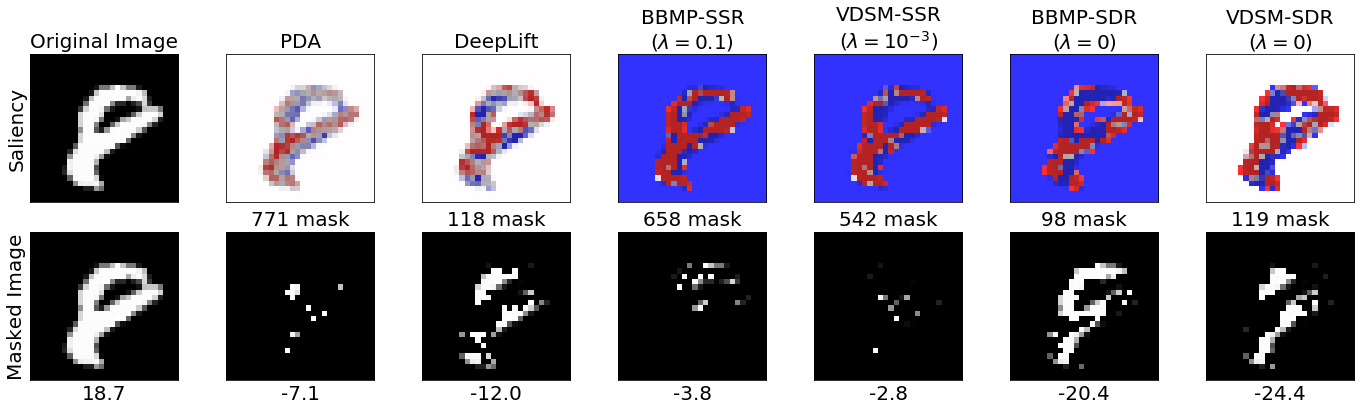

In [27]:
label_arrs = [
    ('PDA', ['../result/1018-8-p_b/8_13_records.th']),
    ('DeepLift', ['../result/deeplift'], mean_model, [13]),
    ('BBMP-SSR\n($\lambda=0.1$)', ['../result/1018-8-bbmp-ssr-0.1/8_13_records.th']),
    ('VDSM-SSR\n($\lambda=10^{-3}$)', ['../result/1018-8-vbd_l1-1E-3/8_13_records.th']),
    ('BBMP-SDR\n($\lambda=0$)', ['../result/1018-8-bbmp-sdr-0/8_13_records.th']),
    ('VDSM-SDR\n($\lambda=0$)', ['../result/1018-8-vbd_l1_opposite-0/8_13_records.th']),
]
fig = plot_comparison(label_arrs, from_class=8, to_class=None)
fig.savefig('flip_8_example.eps', format='eps', dpi=200, bbox_inches='tight')

## Flip 8 and keep
- No hyperparameter selection for SDR

num_methods: 6
Done!


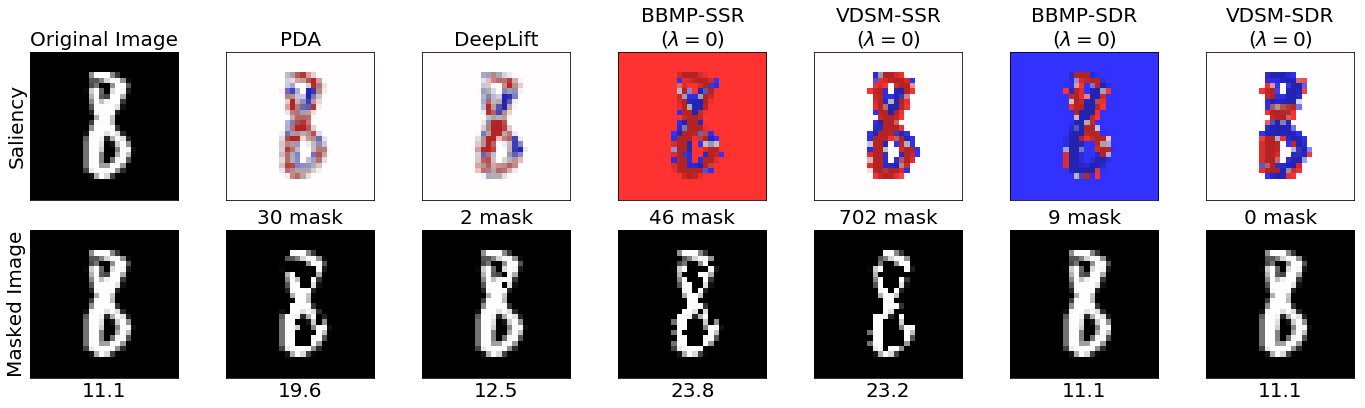

In [33]:
label_arrs = [
    ('PDA', ['../result/1018-8-p_b/8_14_records.th']),
    ('DeepLift', ['../result/deeplift'], mean_model, [14]),
    ('BBMP-SSR\n($\lambda=0$)', ['../result/1018-8-bbmp-ssr-0/8_14_records.th']),
    ('VDSM-SSR\n($\lambda=0$)', ['../result/1018-8-vbd_l1-0/8_14_records.th']),
    ('BBMP-SDR\n($\lambda=0$)', ['../result/1018-8-bbmp-sdr-0/8_14_records.th']),
    ('VDSM-SDR\n($\lambda=0$)', ['../result/1018-8-vbd_l1_opposite-0/8_14_records.th']),
]
fig = plot_comparison_keep_region(label_arrs, from_class=8, to_class=None, percs=None)
fig.savefig('keep_8_example.eps', format='eps', dpi=200, bbox_inches='tight')

## Flip 8 summary

Find cache for DeepLift
Find cache for BBMP-SSR
($\lambda=0.1$)
Find cache for FIDO-SSR
($\lambda=10^{-3}$)
Find cache for BBMP-SDR
($\lambda=0$)
Find cache for FIDO-SDR
($\lambda=0$)


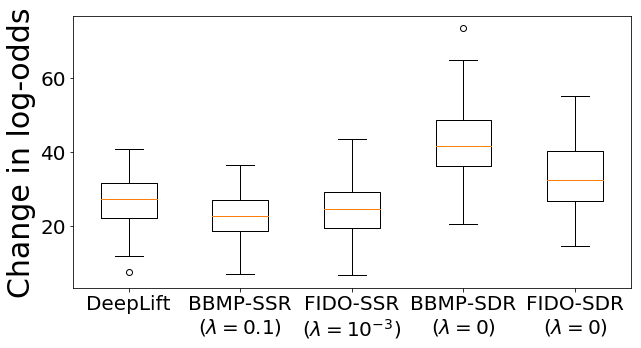

In [11]:
method_names = [
#     ('PDA', '1018-8-p_b'),
    ('DeepLift', ''),
    ('BBMP-SSR\n($\lambda=0.1$)', '1018-8-bbmp-ssr-0.1'),
    ('FIDO-SSR\n($\lambda=10^{-3}$)', '1018-8-vbd_l1-1E-3'),
    ('BBMP-SDR\n($\lambda=0$)', '1018-8-bbmp-sdr-0'),
    ('FIDO-SDR\n($\lambda=0$)', '1018-8-vbd_l1_opposite-0'),
]
fig_flip_8_box_plot = plot_flip_all_box_plot(method_names, impant_model=mean_model, 
                                             from_class=8, to_class=None, total_imgs=100)
# fig_flip_8_box_plot.savefig('flip_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

Find cache for PDA
Find cache for DeepLift
Find cache for BBMP-SSR
($\lambda=0$)
Find cache for VDSM-SSR
($\lambda=0$)
Find cache for BBMP-SDR
($\lambda=0$)
Find cache for VDSM-SDR
($\lambda=0$)


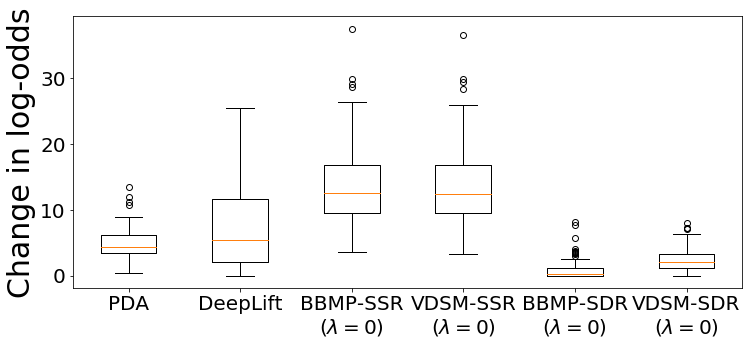

In [15]:
method_names = [
    ('PDA', '1018-8-p_b'),
    ('DeepLift', ''),
    ('BBMP-SSR\n($\lambda=0$)', '1018-8-bbmp-ssr-0'),
    ('VDSM-SSR\n($\lambda=0$)', '1018-8-vbd_l1-0'),
    ('BBMP-SDR\n($\lambda=0$)', '1018-8-bbmp-sdr-0'),
    ('VDSM-SDR\n($\lambda=0$)', '1018-8-vbd_l1_opposite-0'),
]
fig_keep_8_box_plot = plot_keep_all_box_plot(method_names, from_class=8, to_class=None, total_imgs=100)
fig_keep_8_box_plot.savefig('keep_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

## VAE with flipping 8

In [19]:
from arch.Inpainting.VAE_InpaintingMnist import VAE_InpaintingMnist
vae_model = VAE_InpaintingMnist()
states = torch.load('../checkpts/1017-vae-mnist_lr_0.001_epochs_10',
                    map_location=lambda storage, loc: storage)
vae_model.load_state_dict(states['state_dict'])
vae_model.eval()
print 'Load VAE'

num_training: 50000
Load VAE


### VAE Hyperparameter boxplot

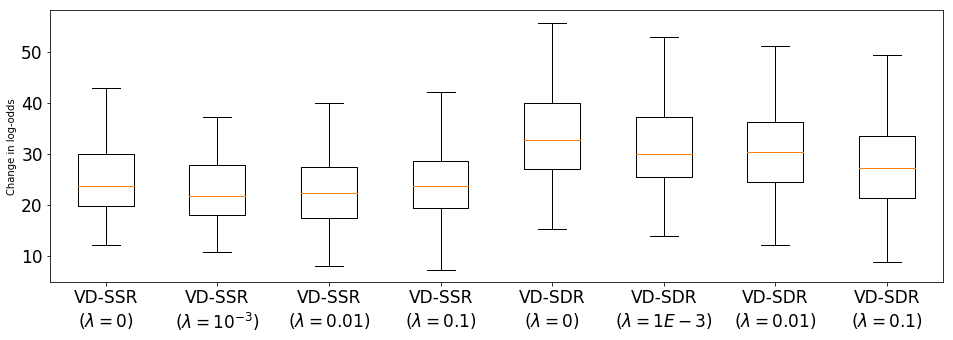

In [24]:
method_names = [
    ('VDSM-SSR\n($\lambda=0$)', '1028-8-vae-vbdl1-0'),
    ('VDSM-SSR\n($\lambda=10^{-3}$)', '1028-8-vae-vbdl1-1E-3'),
    ('VDSM-SSR\n($\lambda=0.01$)', '1028-8-vae-vbdl1-0.01'),
    ('VDSM-SSR\n($\lambda=0.1$)', '1028-8-vae-vbdl1-0.1'),
    ('VDSM-SDR\n($\lambda=0$)', '1028-8-vae-vbd_l1_opposite-0'),
    ('VDSM-SDR\n($\lambda=1E-3$)', '1028-8-vae-vbd_l1_opposite-1E-3'),
    ('VDSM-SDR\n($\lambda=0.01$)', '1028-8-vae-vbd_l1_opposite-0.01'),
    ('VDSM-SDR\n($\lambda=0.1$)', '1028-8-vae-vbd_l1_opposite-0.1'),
]
vae_fig_flip_8_box_plot = plot_flip_all_box_plot(method_names, impant_model=vae_model, 
                                                 from_class=8, to_class=None, total_imgs=100)
vae_fig_flip_8_box_plot.savefig('vae_hyper_search_flip_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

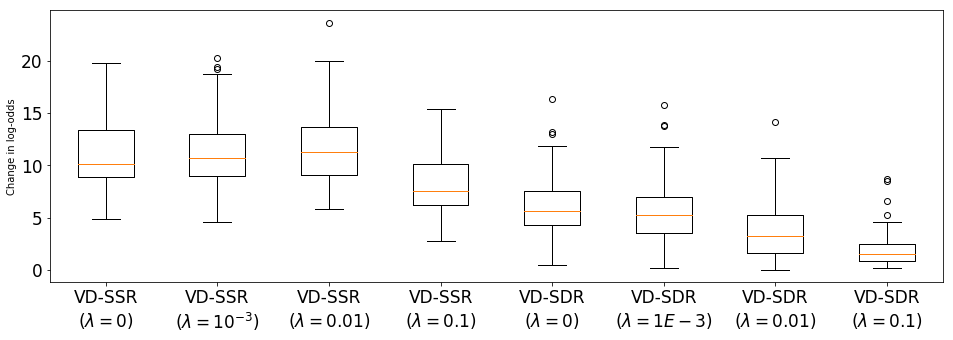

In [25]:
method_names = [
    ('VDSM-SSR\n($\lambda=0$)', '1028-8-vae-vbdl1-0'),
    ('VDSM-SSR\n($\lambda=10^{-3}$)', '1028-8-vae-vbdl1-1E-3'),
    ('VDSM-SSR\n($\lambda=0.01$)', '1028-8-vae-vbdl1-0.01'),
    ('VDSM-SSR\n($\lambda=0.1$)', '1028-8-vae-vbdl1-0.1'),
    ('VDSM-SDR\n($\lambda=0$)', '1028-8-vae-vbd_l1_opposite-0'),
    ('VDSM-SDR\n($\lambda=1E-3$)', '1028-8-vae-vbd_l1_opposite-1E-3'),
    ('VDSM-SDR\n($\lambda=0.01$)', '1028-8-vae-vbd_l1_opposite-0.01'),
    ('VDSM-SDR\n($\lambda=0.1$)', '1028-8-vae-vbd_l1_opposite-0.1'),
]
vae_fig_keep_8_box_plot = plot_keep_all_box_plot(method_names, impant_model=vae_model, 
                                                 from_class=8, to_class=None, total_imgs=100)
vae_fig_keep_8_box_plot.savefig('vae_hyper_search_keep_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

## VAE box plot in deletion task

Find cache for PDA
VAE
Find cache for VDSM-SSR
VAE
($\lambda=0.01$)
Find cache for VDSM-SDR
VAE
($\lambda=10^{-3}$)


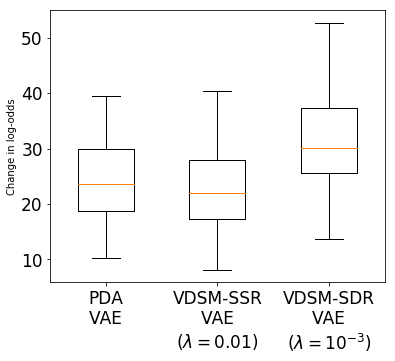

In [29]:
method_names = [
#     ('PDA\nBlack', '1018-8-p_b'),
#     ('VD-SSR\nBlack\n($\lambda=10^{-3}$)', '1018-8-vbd_l1-1E-3'),
#     ('VD-SDR\nBlack\n($\lambda=0$)', '1018-8-vbd_l1_opposite-0'),
    ('PDA\nVAE', '1028-8-vae-p_b'),
    ('VDSM-SSR\nVAE\n($\lambda=0.01$)', '1028-8-vae-vbdl1-0.01'),
    ('VDSM-SDR\nVAE\n($\lambda=10^{-3}$)', '1028-8-vae-vbd_l1_opposite-1E-3'),
]
vae_fig_flip_8_box_plot = plot_flip_all_box_plot(method_names, impant_model=vae_model, 
                                                 from_class=8, to_class=None, total_imgs=100)
vae_fig_flip_8_box_plot.savefig('vae_flip_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

Find cache for PDA
VAE
Find cache for VDSM-SSR
VAE
($\lambda=0.01$)
Find cache for VDSM-SDR
VAE
($\lambda=10^{-3}$)


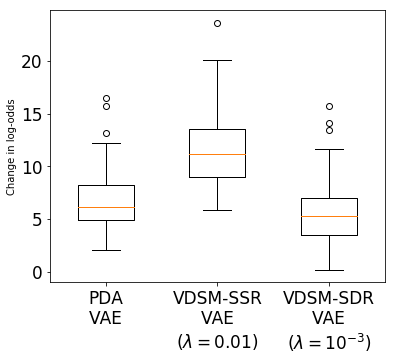

In [30]:
method_names = [
#     ('PDA\nBlack', '1018-8-p_b'),
#     ('VD-SSR\nBlack\n($\lambda=0$)', '1018-8-vbd_l1-0'),
#     ('VD-SDR\nBlack\n($\lambda=0$)', '1018-8-vbd_l1_opposite-0'),
    ('PDA\nVAE', '1028-8-vae-p_b'),
    ('VDSM-SSR\nVAE\n($\lambda=0.01$)', '1028-8-vae-vbdl1-0.01'),
    ('VDSM-SDR\nVAE\n($\lambda=10^{-3}$)', '1028-8-vae-vbd_l1_opposite-1E-3'),
]
vae_fig_keep_8_box_plot = plot_keep_all_box_plot(method_names, impant_model=vae_model, 
                                                 from_class=8, to_class=None, total_imgs=100)
vae_fig_keep_8_box_plot.savefig('vae_keep_8_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!


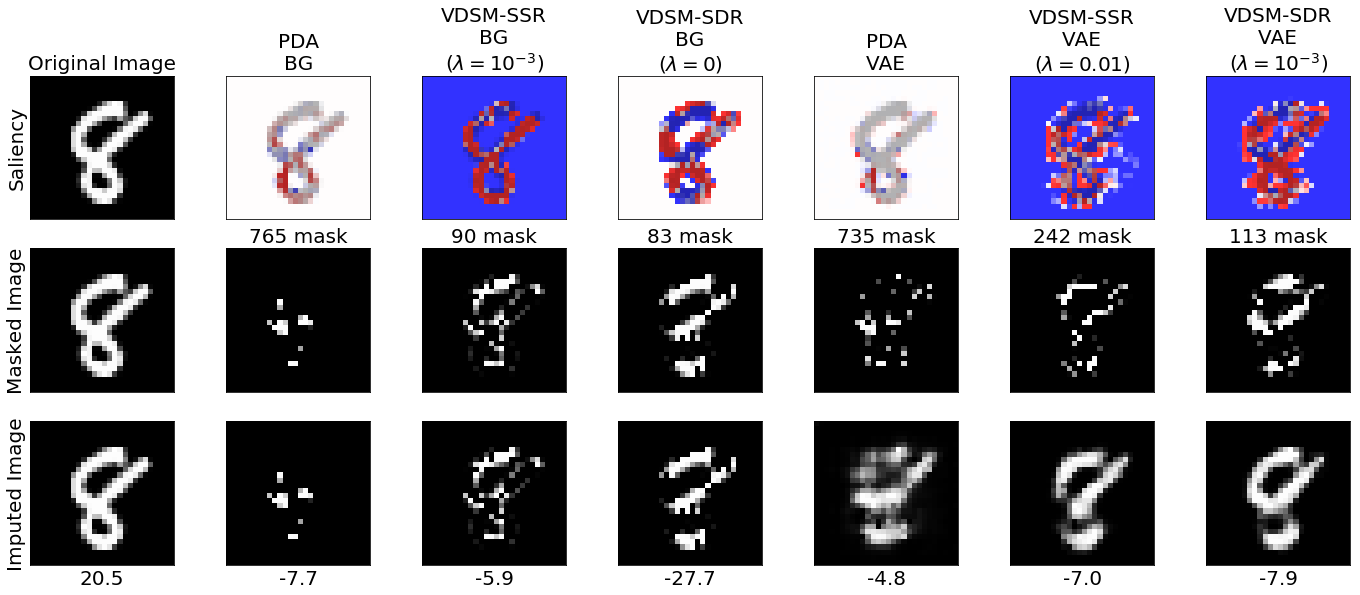

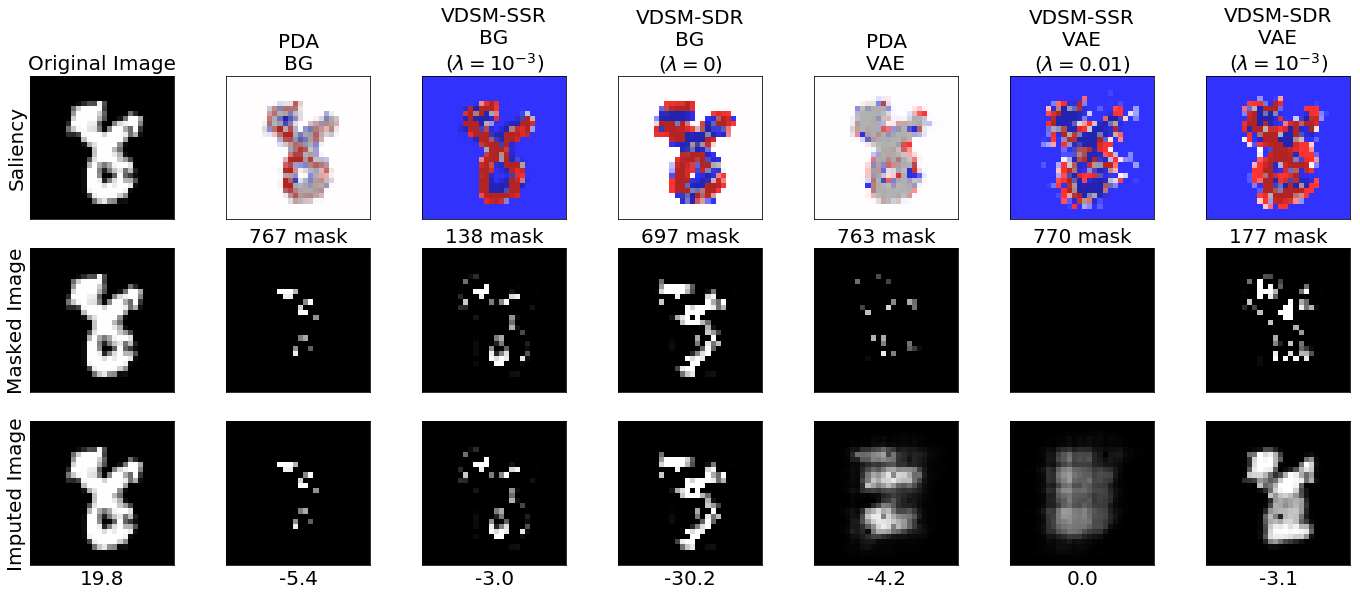

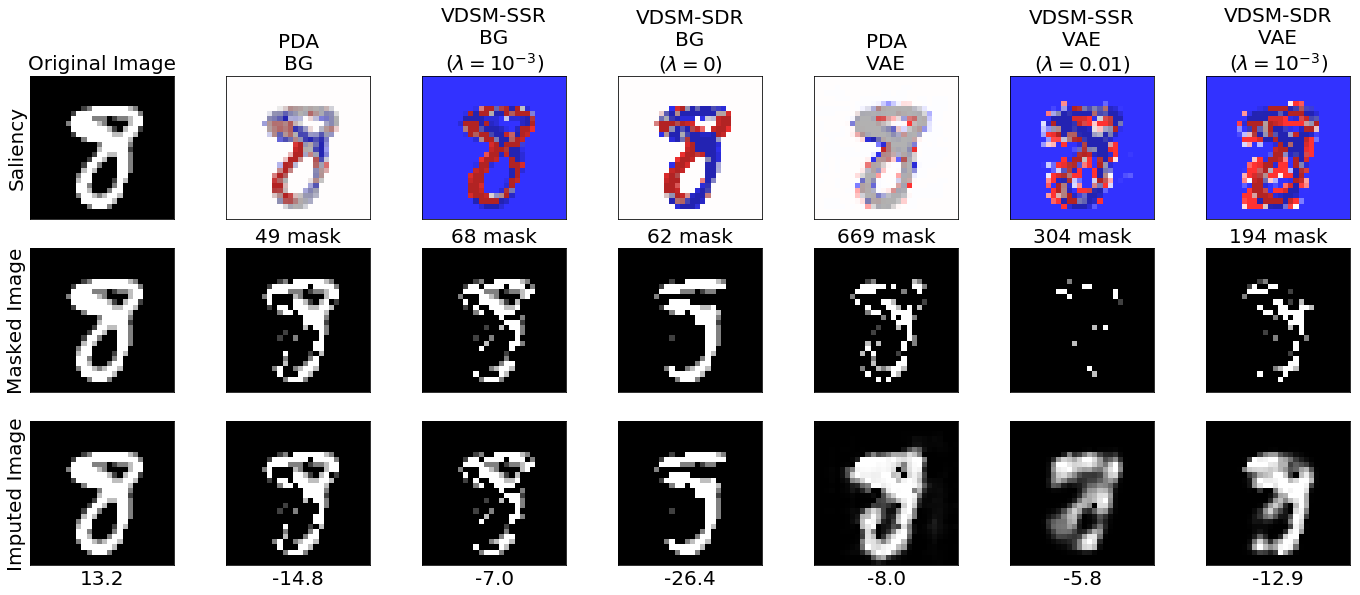

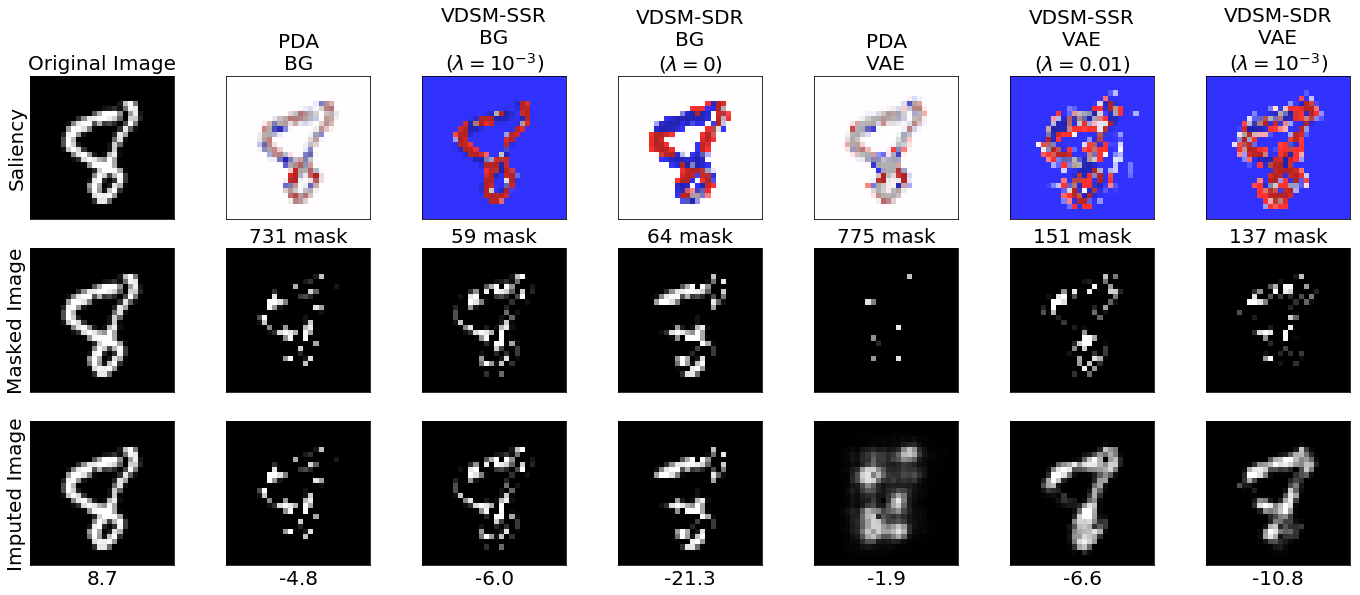

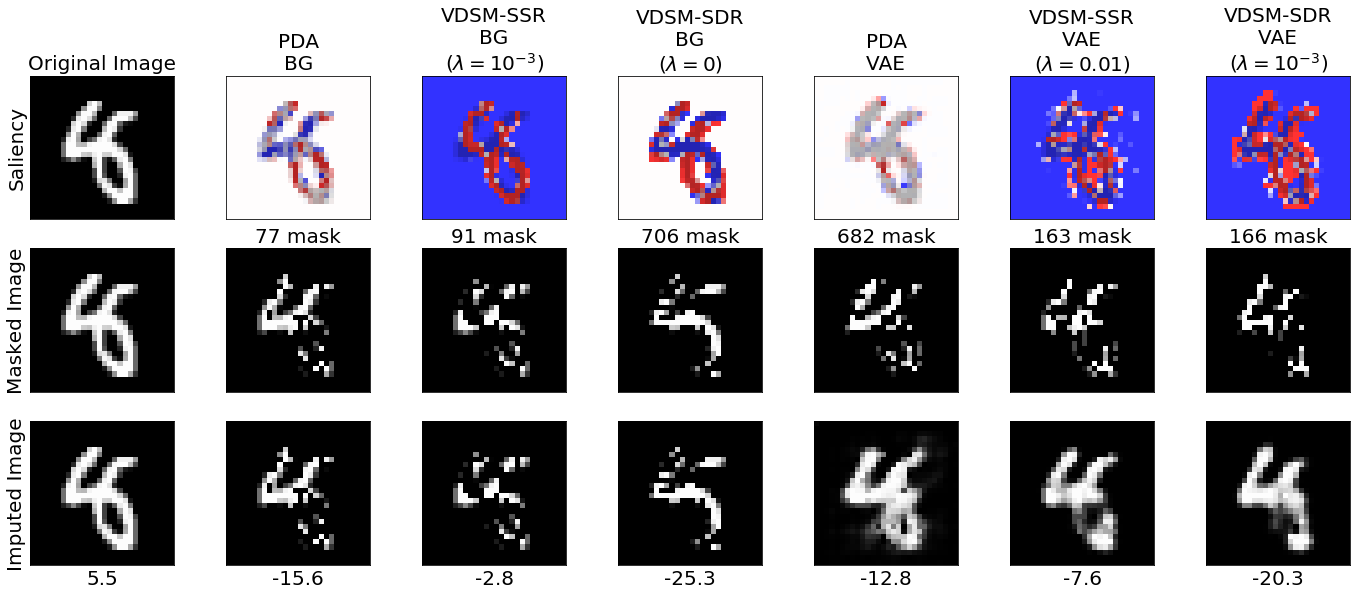

In [38]:
for i in [5, 10, 34, 28, 19]:
    label_arrs = [
        ('PDA\nBG', ['../result/1018-8-p_b/8_%d_records.th' % i], mean_model),
        ('VDSM-SSR\nBG\n($\lambda=10^{-3}$)', ['../result/1018-8-vbd_l1-1E-3/8_%d_records.th' % i], mean_model),
        ('VDSM-SDR\nBG\n($\lambda=0$)', ['../result/1018-8-vbd_l1_opposite-0/8_%d_records.th' % i], mean_model),
        ('PDA\nVAE', ['../result/1028-8-vae-p_b/8_%d_records.th' % i], vae_model),
        ('VDSM-SSR\nVAE\n($\lambda=0.01$)', ['../result/1028-8-vae-vbdl1-0.01/8_%d_records.th' % i], vae_model),
        ('VDSM-SDR\nVAE\n($\lambda=10^{-3}$)', ['../result/1028-8-vae-vbd_l1_opposite-1E-3/8_%d_records.th' % i], vae_model),
    ]
    fig = plot_comparison(label_arrs, impant_model=mean_model, is_vae=True, from_class=8, to_class=None)
    fig.savefig('vae_flip_8_example_%d.eps' % i, format='eps', dpi=200, bbox_inches='tight')

num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!
num_methods: 6
Done!


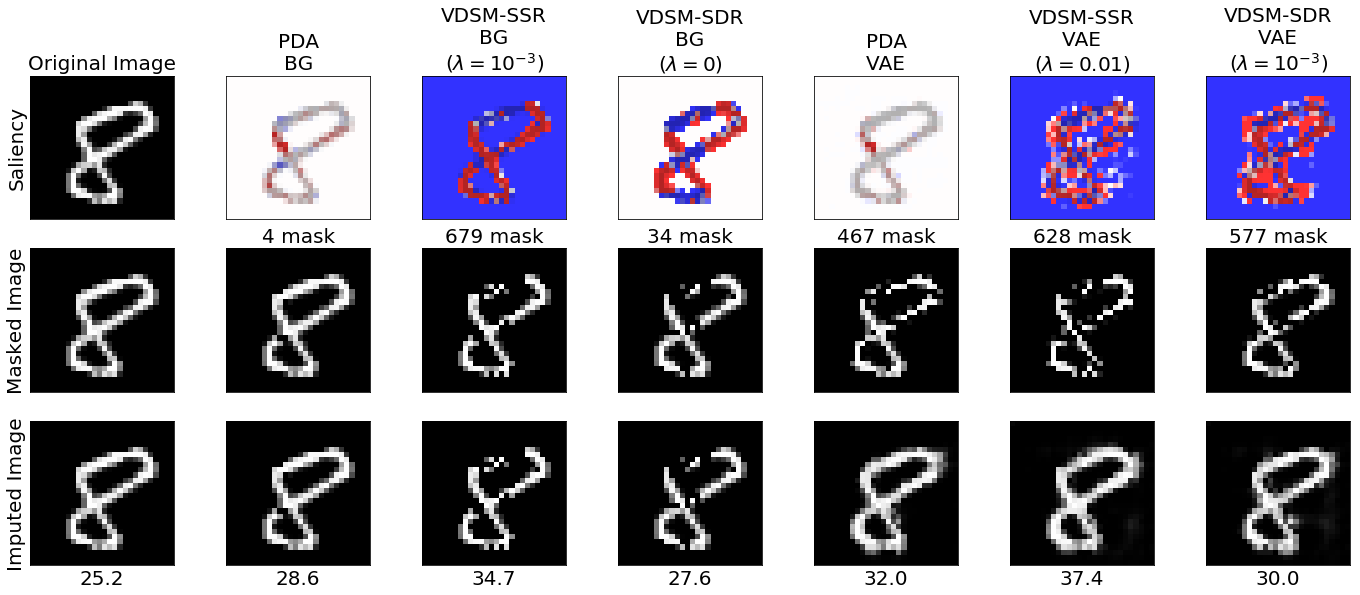

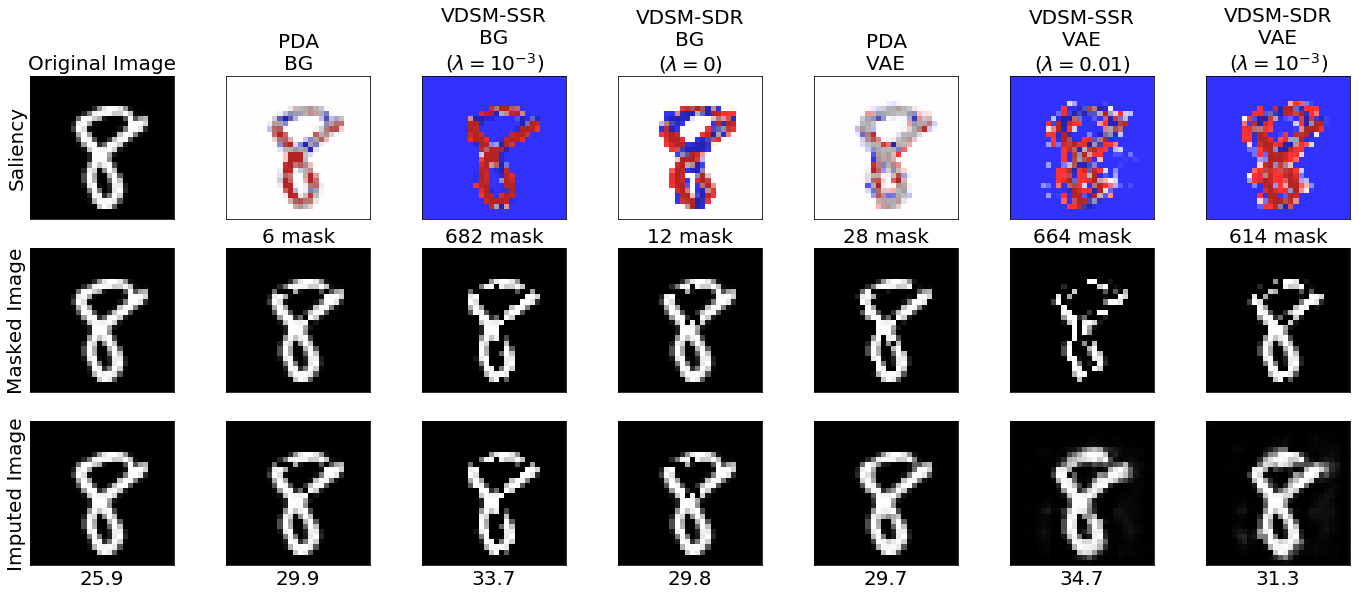

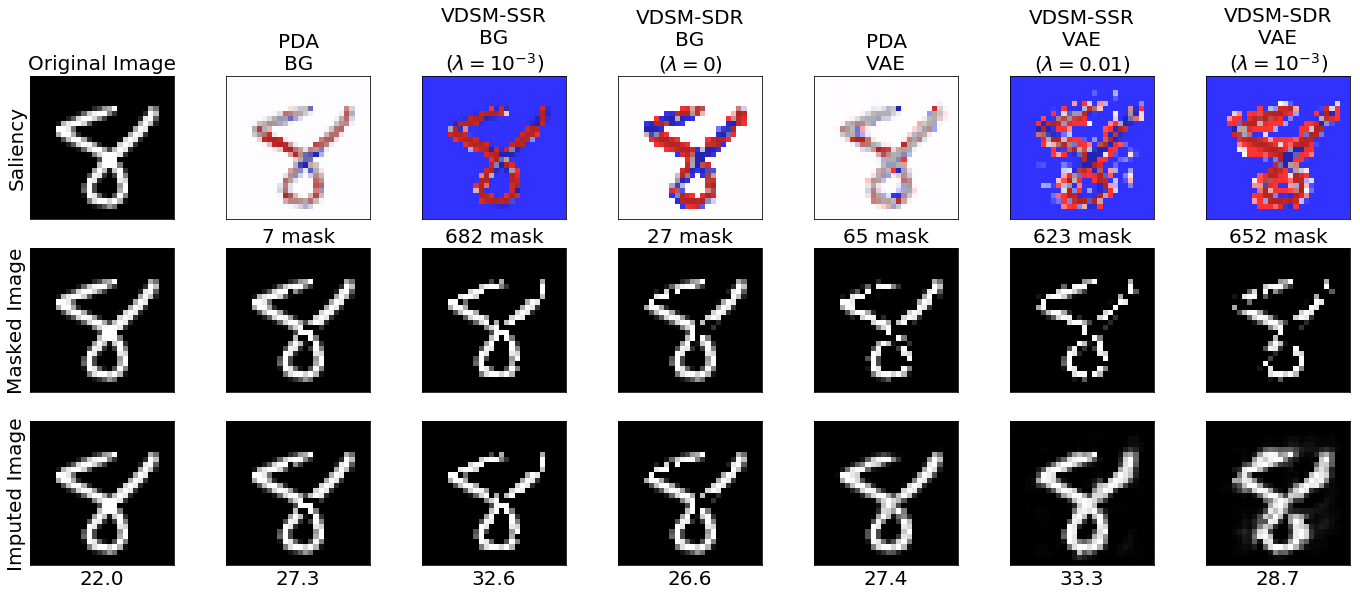

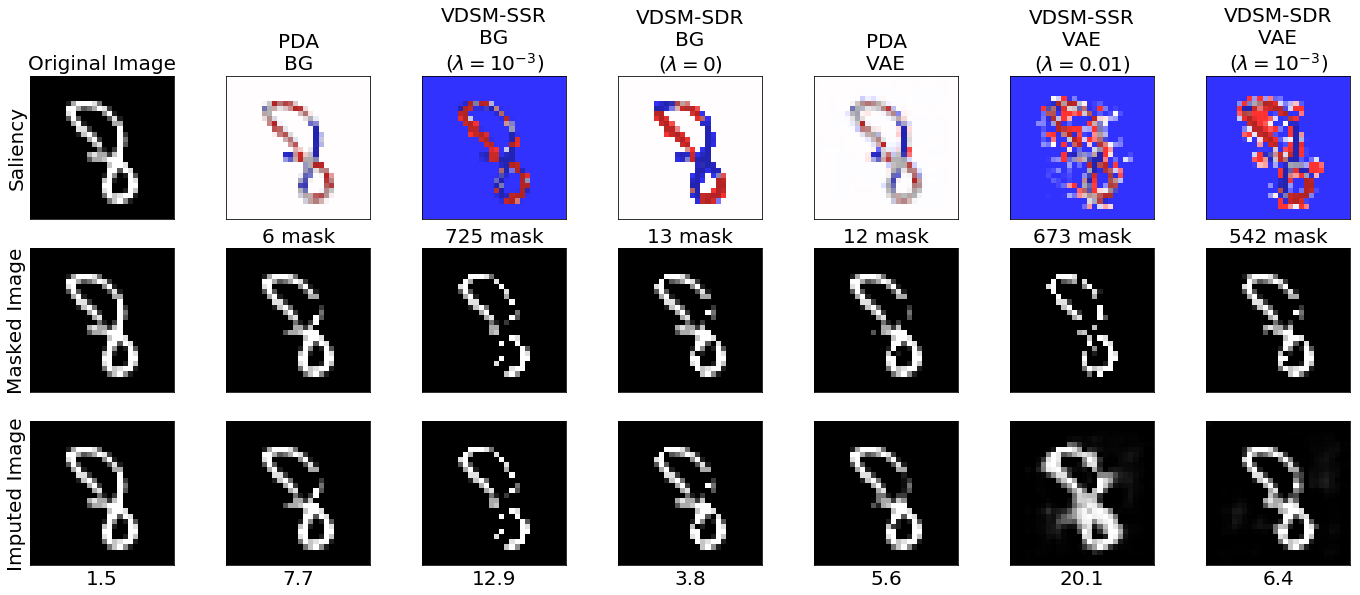

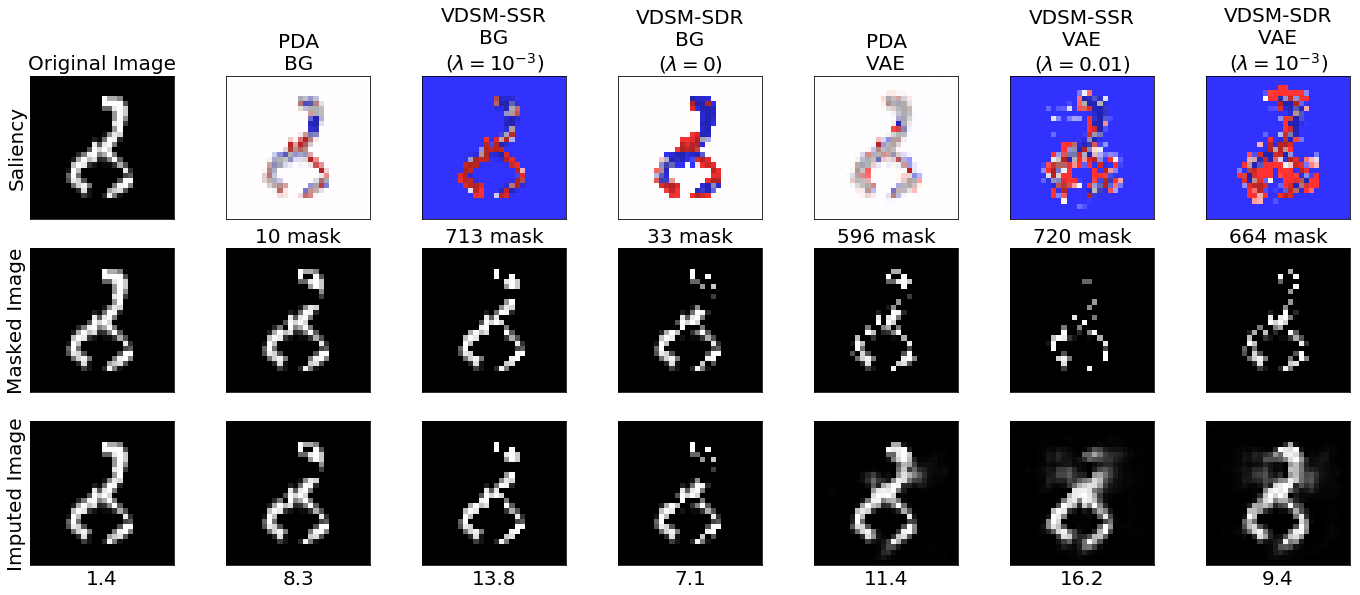

In [52]:
for idx in [15, 33, 38, 44, 49]:
    label_arrs = [
        ('PDA\nBG', ['../result/1018-8-p_b/8_%d_records.th' % idx], mean_model),
        ('VDSM-SSR\nBG\n($\lambda=10^{-3}$)', ['../result/1018-8-vbd_l1-1E-3/8_%d_records.th' % idx], mean_model),
        ('VDSM-SDR\nBG\n($\lambda=0$)', ['../result/1018-8-vbd_l1_opposite-0/8_%d_records.th' % idx], mean_model),
        ('PDA\nVAE', ['../result/1028-8-vae-p_b/8_%d_records.th' % idx], vae_model),
        ('VDSM-SSR\nVAE\n($\lambda=0.01$)', ['../result/1028-8-vae-vbdl1-0.01/8_%d_records.th' % idx], vae_model),
        ('VDSM-SDR\nVAE\n($\lambda=10^{-3}$)', ['../result/1028-8-vae-vbd_l1_opposite-1E-3/8_%d_records.th' % idx], vae_model),
    ]
    fig = plot_comparison_keep_region(label_arrs, is_vae=True, from_class=8, to_class=None, percs=None)
    fig.savefig('vae_keep_8_example_%d.eps' % idx, format='eps', dpi=200, bbox_inches='tight')

## 8 to 3

In [12]:
method_names = [
    ('Perturbation', '1013-p_b'),
    ('DeepLift', ''),
    ('BBMP-SSR\n($\lambda=0.1$)', '1018-bbmp-ssr-0.1'),
    ('VD-SSR\n($\lambda=10^{-3}$)', '1018-vbd_l1-1E-3'),
    ('BBMP-SDR\n($\lambda=0$)', '1018-bbmp-sdr-0'),
    ('VD-SDR\n($\lambda=0$)', '1013-vbd_l1_opposite-0'),
]

Find cache for DeepLift


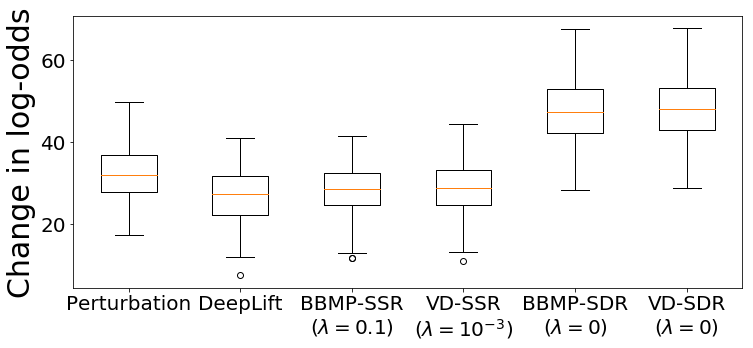

In [13]:
fig_flip_8_3_box_plot = plot_flip_all_box_plot(method_names, from_class=8, to_class=3, total_imgs=1000)
fig_flip_8_3_box_plot.savefig('flip_8_3_box_plot_new_final.eps', format='eps', dpi=300, bbox_inches='tight')

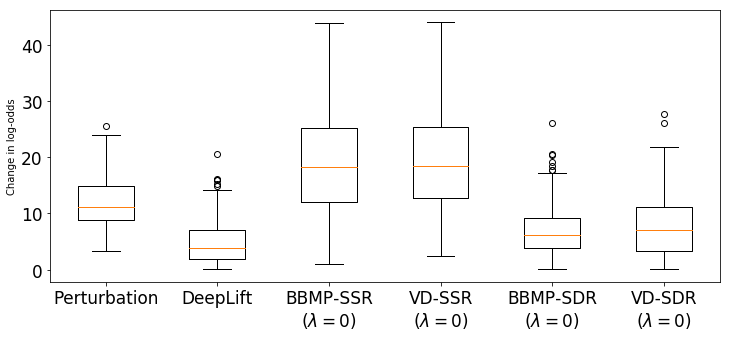

In [12]:
method_names = [
    ('PDA', '1013-p_b'),
    ('DeepLift', ''),
    ('BBMP-SSR\n($\lambda=0$)', '1018-bbmp-ssr-0'),
    ('VD-SSR\n($\lambda=0$)', '1018-vbd_l1-0'),
    ('BBMP-SDR\n($\lambda=0$)', '1018-bbmp-sdr-0'),
    ('VD-SDR\n($\lambda=0$)', '1013-vbd_l1_opposite-0'),
]
fig_keep_8_3_box_plot = plot_keep_all_box_plot(method_names, from_class=8, to_class=3, total_imgs=100)
fig_keep_8_3_box_plot.savefig('keep_8_3_box_plot.eps', format='eps', dpi=300, bbox_inches='tight')

num_methods: 6
Done!


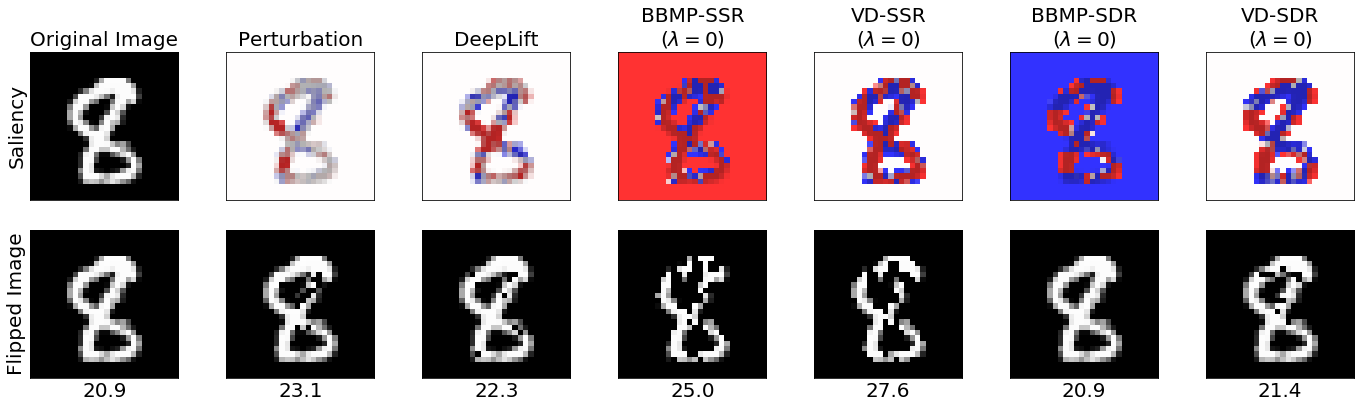

In [4]:
label_arrs = [
    ('PDA', ['../result/1013-p_b/8_3_24_records.th']),
    ('DeepLift', [''], [24]),
    ('BBMP-SSR\n($\lambda=0$)', ['../result/1018-bbmp-ssr-0/8_24_records.th']),
    ('VD-SSR\n($\lambda=0$)', ['../result/1018-vbd_l1-0/8_24_records.th']),
    ('BBMP-SDR\n($\lambda=0$)', ['../result/1018-bbmp-sdr-0/8_24_records.th']),
    ('VD-SDR\n($\lambda=0$)', ['../result/1013-vbd_l1_opposite-0/8_24_records.th']),
]
fig = plot_comparison_keep_region(label_arrs, from_class=8, to_class=None, percs=None)
fig.savefig('keep_8_3_example.eps', format='eps', dpi=200, bbox_inches='tight')

num_methods: 6
Done!


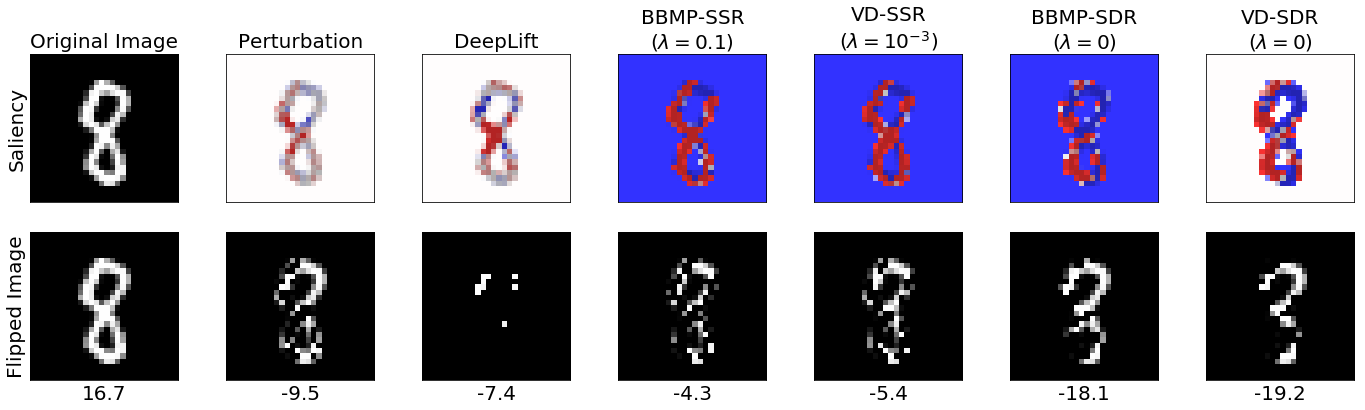

In [8]:
label_arrs = [
    ('PDA', ['../result/1013-p_b/8_3_55_records.th']),
    ('DeepLift', [''], [55]),
    ('BBMP-SSR\n($\lambda=0.1$)', ['../result/1018-bbmp-ssr-0.1/8_55_records.th']),
    ('VD-SSR\n($\lambda=10^{-3}$)', ['../result/1018-vbd_l1-1E-3/8_55_records.th']),
    ('BBMP-SDR\n($\lambda=0$)', ['../result/1018-bbmp-sdr-0/8_55_records.th']),
    ('VD-SDR\n($\lambda=0$)', ['../result/1013-vbd_l1_opposite-0/8_55_records.th']),
]
fig = plot_comparison(label_arrs, from_class=8, to_class=None)
fig.savefig('flip_8_3_example.eps', format='eps', dpi=300, bbox_inches='tight')

## Rest of it are old

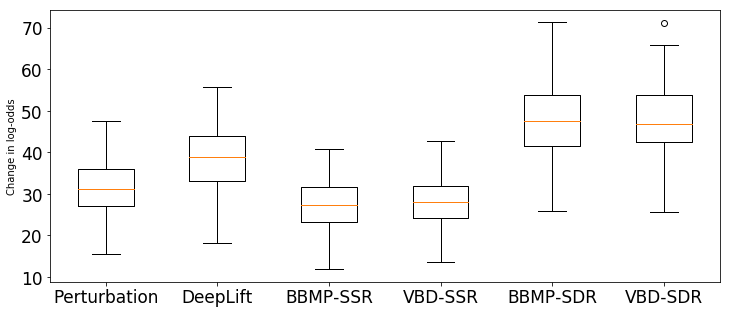

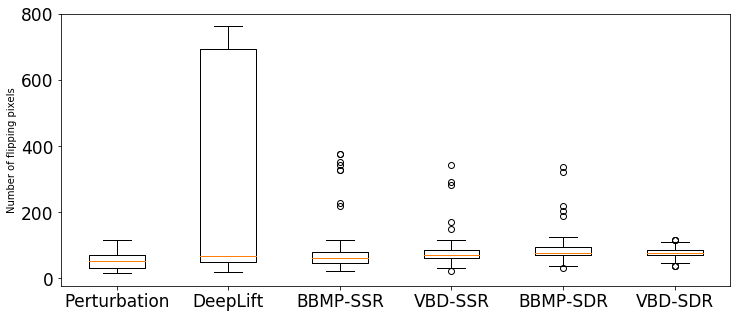

In [131]:
plot_all_box_plot(method_names, from_class=8, to_class=3, total_imgs=100)

In [132]:
method_names = [
    ('Perturbation', '1018-8-p_b'),
    ('DeepLift', ''),
    ('BBMP-SSR', '1018-8-bbmp-ssr-0.01'),
    ('VBD-SSR', '1018-8-vbd_l1-0'),
    ('BBMP-SDR', '1018-8-bbmp-sdr-0'),
    ('VBD-SDR', '1018-8-vbd_l1_opposite-0'),
]

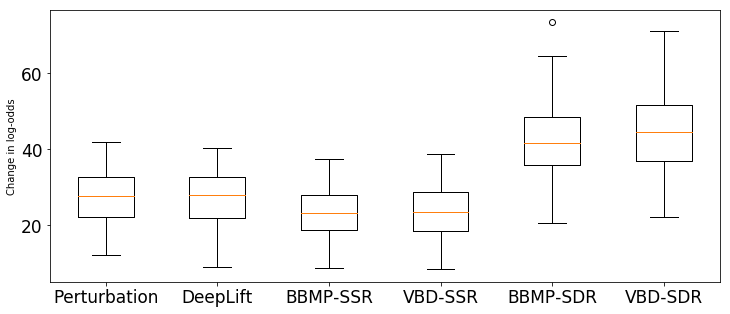

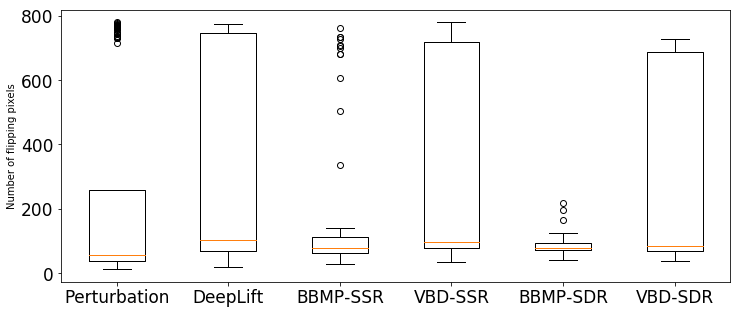

In [133]:
plot_all_box_plot(method_names, from_class=8, to_class=None, total_imgs=100)

In [242]:
label_arrs = [
    ('PDA', ['../result/1013-p_b/8_3_20_records.th']),
    ('DeepLift', [''], [20]),
    ('BBMP\nSSR\n($\lambda=0.1$)', ['../result/1018-bbmp-ssr-0.1/8_20_records.th']),
    ('VD\nSSR\n($\lambda=10^{-3}$)', ['../result/1018-vbd_l1-1E-3/8_20_records.th']),
    ('BBMP\nSDR\n($\lambda=0$)', ['../result/1018-bbmp-sdr-0/8_20_records.th']),
    ('VD\nSDR\n($\lambda=0$)', ['../result/1013-vbd_l1_opposite-0/8_20_records.th']),
]

num_methods: 6
> <ipython-input-212-d4218454354d>(205)plot_comparison()
-> fig, axes = plt.subplots(2, 1 + num_methods, figsize=(num_methods * 4, 6))
(Pdb) c
Perturbation
DeepLift
BBMP
SSR
($\lambda=0.1$)
VD
SSR
($\lambda=10^{-3}$)
BBMP
SDR
($\lambda=0$)
VD
SDR
($\lambda=0$)
Done!


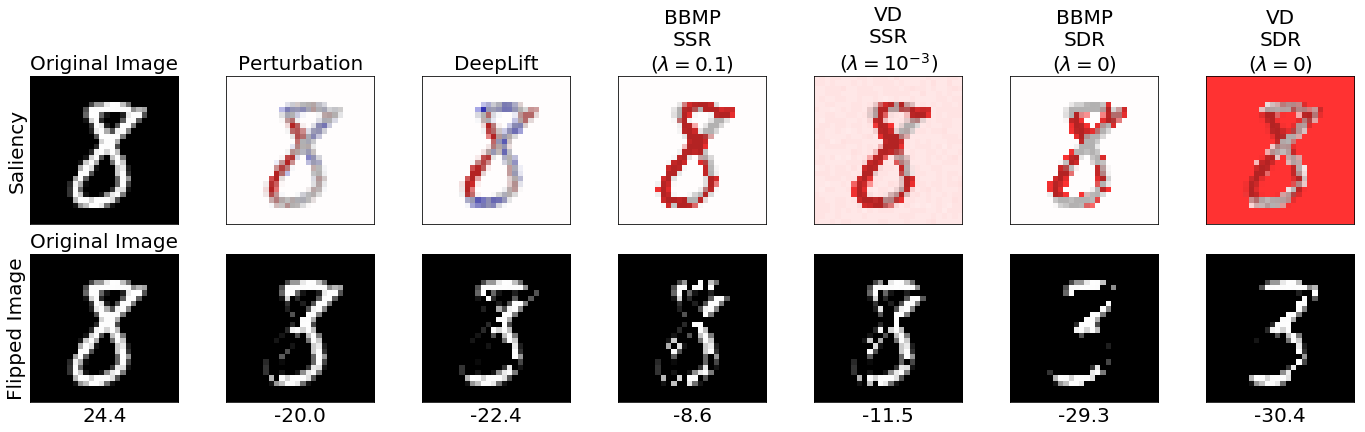

In [217]:
fig = plot_comparison(label_arrs, from_class=8, to_class=3)

num_methods: 6
Done!


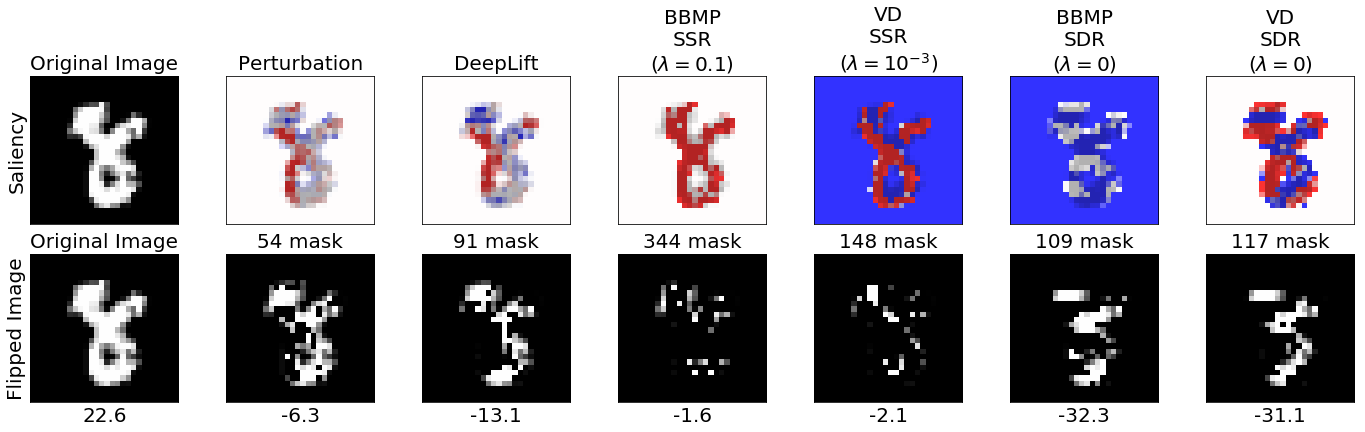

In [161]:
fig = plot_comparison(label_arrs, from_class=8, to_class=3)

In [178]:
label_arrs = [
    ('PDA', '../result/1013-p_b/8_3_11_records.th'),
#     ('Variational\nDropout\n($\lambda=0.1$)', '../result/1013-vbd_l1_opposite-0.1/8_11_records.th'),
    ('DeepLift', '../result/1018-deeplift/mnist_deeplift_scores.pth', 11),
    ('BBMP\nSSR\n($\lambda=0.1$)', '../result/1018-bbmp-ssr-0.1/8_11_records.th'),
    ('VD\nSSR\n($\lambda=10^{-3}$)', '../result/1018-vbd_l1-1E-3/8_11_records.th'),
    ('BBMP\nSDR\n($\lambda=0$)', '../result/1018-bbmp-sdr-0/8_11_records.th'),
    ('VD\nSDR\n($\lambda=0$)', '../result/1013-vbd_l1_opposite-0/8_11_records.th'),
]

num_methods: 6
Done!


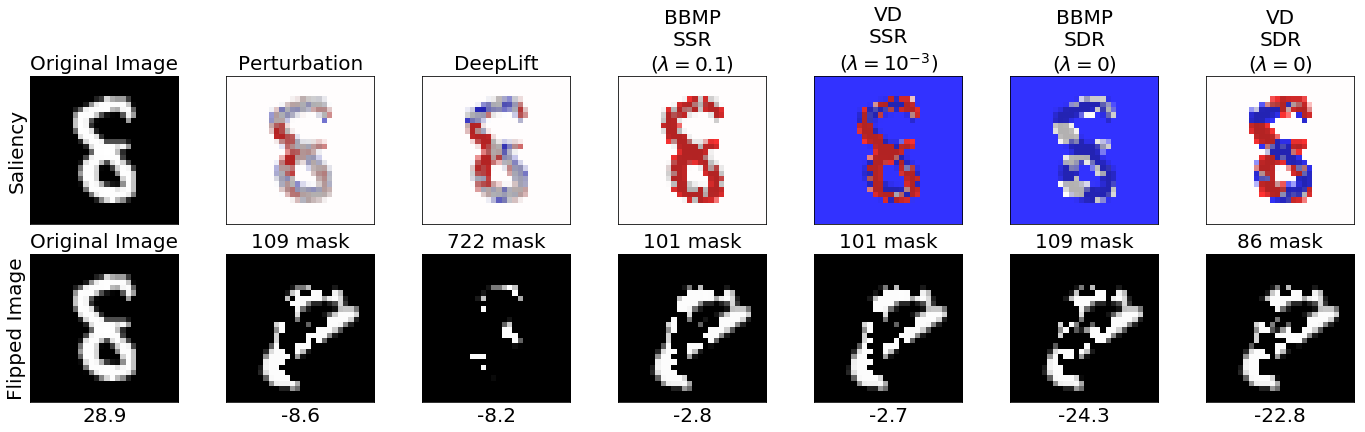

In [179]:
fig = plot_comparison(label_arrs, from_class=8, to_class=3)

num_methods: 6
Done!


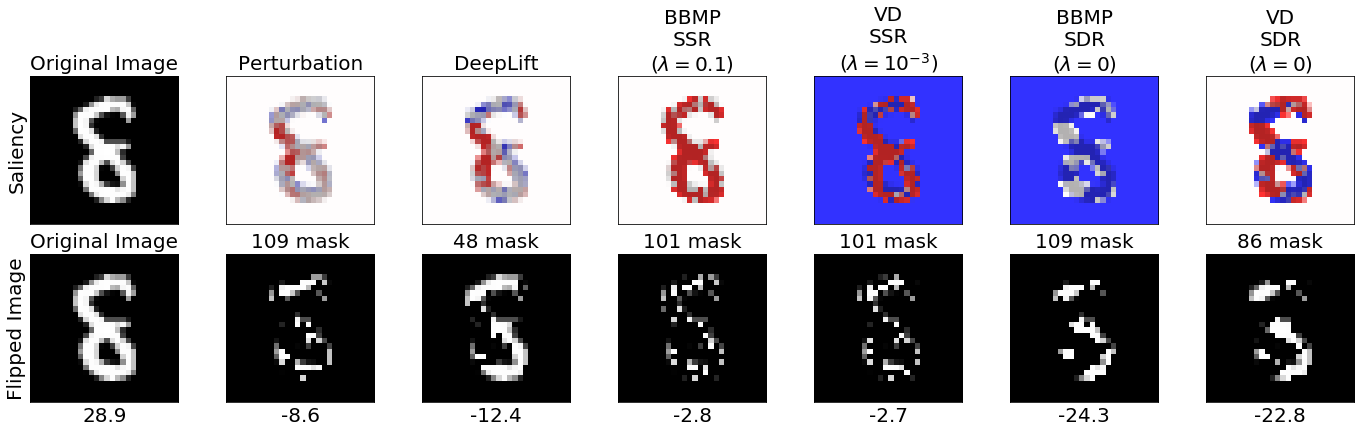

In [163]:
fig = plot_comparison(label_arrs, from_class=8, to_class=3)

## 

## Only flip 8

In [25]:
label_arrs = [
    ('PDA', '../result/1018-8-p_b/8_13_records.th'),
    ('DeepLift', '../result/1018-deeplift/mnist_deeplift_scores.pth', 13),
    ('BBMP\nSSR\n($\lambda=0.1$)', '../result/1018-8-bbmp-ssr-0.1/8_13_records.th'),
    ('VD\nSSR\n($\lambda=10^{-3}$)', '../result/1018-8-vbd_l1-1E-3/8_13_records.th'),
    ('BBMP\nSDR\n($\lambda=0$)', '../result/1018-8-bbmp-sdr-0/8_13_records.th'),
    ('VD\nSDR\n($\lambda=0$)', '../result/1018-8-vbd_l1_opposite-0/8_13_records.th'),
]
fig = plot_comparison(label_arrs, from_class=8, to_class=None)

num_methods: 6
Done!


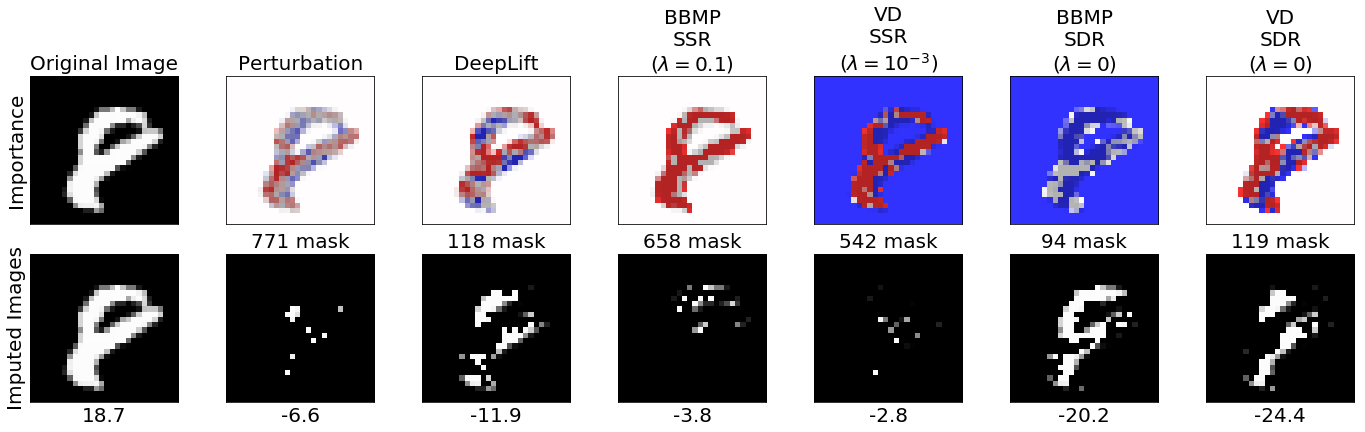

In [26]:
fig = plot_comparison(label_arrs, from_class=8, to_class=None)

## Old

In [137]:
label_arrs = [
    ('PDA', '../result/1018-8-p_b/8_13_records.th'),
    ('DeepLift', '../result/1018-deeplift/mnist_deeplift_scores.pth', 13),
    ('BBMP\nSSR\n($\lambda=0.1$)', '../result/1018-8-bbmp-ssr-0.1/8_13_records.th'),
    ('VD\nSSR\n($\lambda=10^{-3}$)', '../result/1018-8-vbd_l1-1E-3/8_13_records.th'),
    ('BBMP\nSDR\n($\lambda=0$)', '../result/1018-8-bbmp-sdr-0/8_13_records.th'),
    ('VD\nSDR\n($\lambda=0$)', '../result/1018-8-vbd_l1_opposite-0/8_13_records.th'),
]

num_methods: 6


IndexError: tuple index out of range

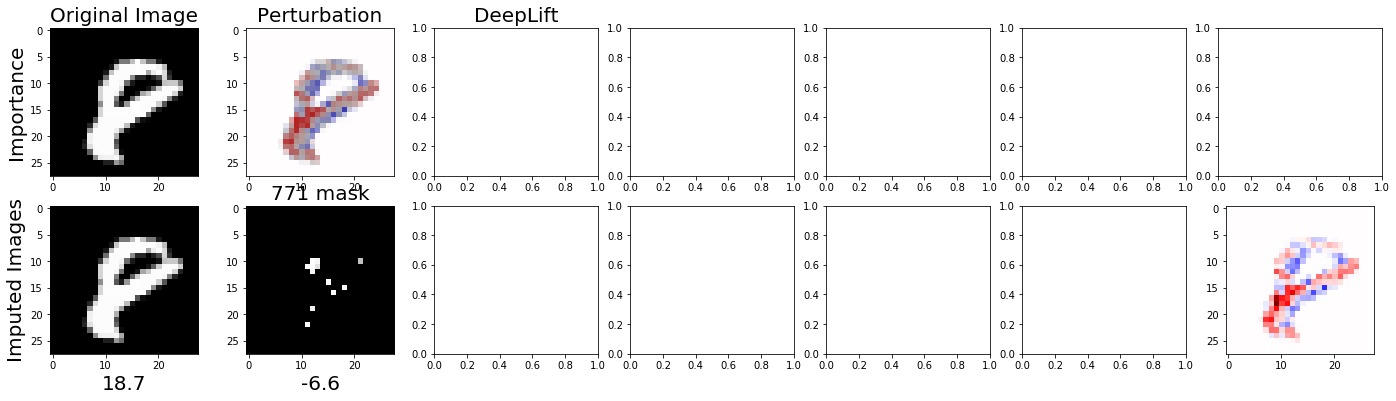

In [135]:
# Start drawing. Open each file_path and plot something!

# num_pixels = [50, 100, 150]

keep_percs = [0.2, 0.1, 0.05]

num_methods = len(label_arrs)
print 'num_methods:', num_methods

fig, axes = plt.subplots(1 + len(keep_percs), 1 + num_methods, 
                         figsize=(num_methods * 4, 3 * (1 + len(keep_percs))))

def plot_imp_vector_img(original_img, imp_vector_dict, ax)

# Assume the first item is Perturbation or VD
_, _, unnormalized_img, _, _ = torch.load(label_arrs[0][1])
im1 = utils_visualise.plot_pytorch_img(unnormalized_img[0, ...].expand(3, 28, 28), axes[0, 0])
im1 = utils_visualise.plot_pytorch_img(unnormalized_img[0, ...].expand(3, 28, 28), axes[1, 0])
axes[0, 0].set_title('Original Image', fontsize=20)
axes[0, 0].set_ylabel('Importance', fontsize=20)
axes[1, 0].set_ylabel('Imputed Images', fontsize=20)

orig_log_odds = get_log_odds_ratio(unnormalized_img, interpret_net, from_class=8, to_class=None)
axes[1, 0].set_xlabel('%.1f' % (orig_log_odds), fontsize=20)

for idx, content in enumerate(label_arrs):
    method_name = content[0]
    file_path = content[1]

    axes[0, (idx + 1)].set_title(method_name, fontsize=20)
    if method_name.startswith('VD') or method_name == 'Perturbation' or method_name.startswith('BBMP'):
        orig_log_odds, all_log_odds, unnormalized_img, imp_vector, random_odds = torch.load(file_path)
    
    elif method_name.startswith('DeepLift'):
        log_odds, _, y_test = torch.load(file_path)
        img_idx = content[2]

        real_idx = np.arange(10000)[y_test == from_digit][img_idx]

        imp_vector = log_odds[from_class][real_idx][0]
        if to_class is not None:
            imp_vector -= log_odds[to_class][real_idx][0]

        all_log_odds = get_all_log_odds(imp_vector, unnormalized_img, interpret_net, 
                                        from_class=from_class, to_class=to_class)
        
    max_log_odds = orig_log_odds
    for num_pixel, log_odd in all_log_odds.iteritems():
        if log_odd > max_log_odds:
            max_num_pixels = num_pixel
            max_log_odds = log_odd
    overlayed_img, clim = utils_visualise.get_overlayed_image(unnormalized_img[0, ...], imp_vector)

    # Plot colored image
    im2 = utils_visualise.plot_pytorch_img(overlayed_img, axes[0, 1 + idx])
        
    # Plot the mask image
    the_mask = iter(mask_gen_to_flip_top_pixels(imp_vector, [max_num_pixels])).next()
    regenerated = impant_model.impute_missing_imgs(unnormalized_img, the_mask)

    log_odds = get_log_odds_ratio(regenerated, interpret_net, from_class=8, to_class=None)
    
    the_ax = axes[1, 1 + idx]
    utils_visualise.plot_pytorch_img(regenerated[0, ...].expand(3, 28, 28), the_ax)
    the_ax.set_xlabel('%.1f' % (log_odds), fontsize=20)
    the_ax.set_title('%d mask' % (max_num_pixels), fontsize=20)

# if 'p_b' not in name:
#     axes[img_idx, -2].

# Closes all the axis    
for ax1 in axes:
    for ax in ax1:
        ax.set_xticks([], [])
        ax.set_yticks([], [])
print 'Done!'
# return fig

In [2]:

#     for name, dir_name in method_names:
#         if name == 'DeepLift':
#             scores, x_test, y_test = torch.load('../result/1018-deeplift/mnist_deeplift_scores.pth')

#             real_idx = np.arange(10000)[y_test == from_class][:total_imgs]
            
#             imgs = x_test[real_idx]
#             imp_vector = scores[from_class][real_idx]
#             if to_class is not None:
#                 imp_vector -= scores[to_class][real_idx]
            
#             arr = []
#             arr2 = []
#             for i in xrange(total_imgs):
#                 torch_img = torch.FloatTensor(imgs[i])
#                 all_log_odds = get_all_log_odds(imp_vector[i][0], torch_img, interpret_net, 
#                                                 from_class=from_class, to_class=to_class)
# #                 import pdb; pdb.set_trace()
#                 max_num_pixels, max_vals = max(all_log_odds.iteritems(), key=operator.itemgetter(1))
#                 arr.append(max_vals - all_log_odds[0])
#                 arr2.append(max_num_pixels)
#             scores_to_plot.append(arr)
#             num_pixels_used.append(arr2)
                
#         else:
#             files = get_file_names(dir_name)

#             arr = []
#             arr2 = []
#             for f in files:
#                 orig_log_odds, all_log_odds, unnormalized_img, imp_vector, rodds = \
#                     torch.load(os.path.join('../result', dir_name, f))

#                 max_num_pixels, max_vals = max(all_log_odds.iteritems(), key=operator.itemgetter(1))
#                 arr.append(max_vals - orig_log_odds)
#                 arr2.append(max_num_pixels)
#             scores_to_plot.append(arr)
#             num_pixels_used.append(arr2)

## Cache the impant and classifier 